In [1]:
import anndata as ad
from scvi.model import SCVI


TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_prot.h5ad"
TABULA_SAPIENS_BY_CELL_TYPE_SCVI_MODEL = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_scvi_model_test/"

adata = ad.read_h5ad(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  

In [2]:
model = SCVI.load(TABULA_SAPIENS_BY_CELL_TYPE_SCVI_MODEL, adata=adata)

INFO     File /Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_featu
         res_scvi_model_test/model.pt already downloaded                                     


/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [3]:
model

SCVI Model with the following params: 
n_hidden: 256, n_latent: 32, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [4]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [5]:
import scanpy as sc


adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)
sc.pp.log1p(adata, layer='scvi_normalized')

In [6]:
adata.layers['counts_normalized'] = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=10e4, layer='counts_normalized')
sc.pp.log1p(adata, layer='counts_normalized')

In [7]:
import numpy as np

X_full = adata.layers['counts_normalized']
X_pred_full = adata.layers['scvi_normalized']

keep_genes = np.logical_not(adata.var['train'])
keep_cells = np.logical_not(adata.obs['train'])

X = X_full[np.ix_(*[keep_cells, keep_genes])]
X_pred = X_pred_full[np.ix_(*[keep_cells, keep_genes])]

loss = ((X_pred - X)**2).mean()
print('loss', loss)

loss 0.23132174


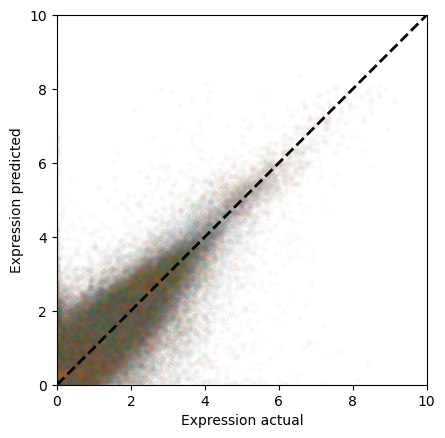

In [8]:
import matplotlib.pyplot as plt

plt.plot(X, X_pred, '.', alpha=0.02);
plt.plot([0, 10], [0, 10], 'k', linewidth='2', linestyle='--')
# plt.xlim([.01, 300]);
# plt.ylim([.01, 300]);
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([0, 10])
plt.ylim([0, 10])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Expression actual');
plt.ylabel('Expression predicted');

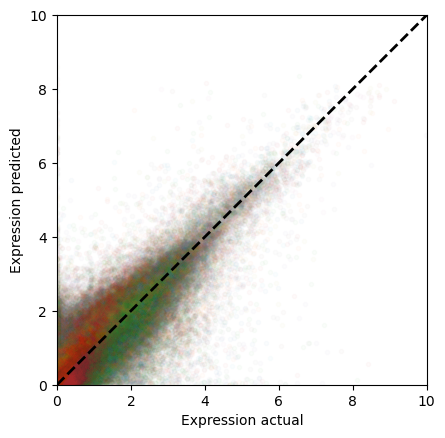

In [9]:
plt.plot(X.T, X_pred.T, '.', alpha=0.02);
plt.plot([0, 10], [0, 10], 'k', linewidth='2', linestyle='--')
# plt.xlim([.01, 300]);
# plt.ylim([.01, 300]);
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([0, 10])
plt.ylim([0, 10])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Expression actual');
plt.ylabel('Expression predicted');

In [10]:
from scipy.stats import pearsonr
import numpy as np

In [11]:
pearsonr(X_pred.ravel(), X.ravel()).statistic # 0.8015168898517756

0.8932518338513842

In [12]:
r_values_across_cells = np.array([pearsonr(a, b).statistic for a, b in zip(X_pred.T, X.T)])
r_values_across_cells[np.isnan(r_values_across_cells)] = 0
print(len(r_values_across_cells), r_values_across_cells.mean())

5791 0.41684245834648187


/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


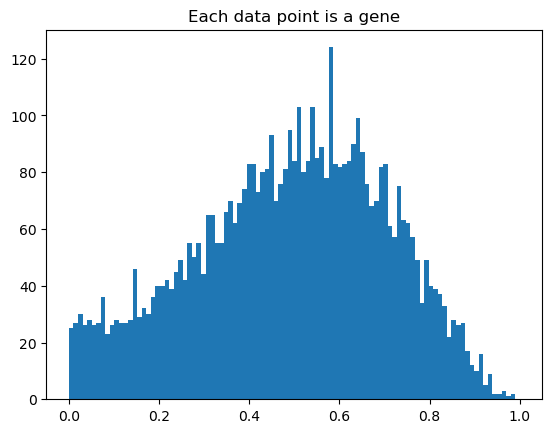

In [13]:
plt.hist(r_values_across_cells, bins=np.linspace(0, 1, 100));
plt.title('Each data point is a gene');

In [14]:
mse_across_cells = np.array([((a-b)**2).mean() for a, b in zip(X_pred.T, X.T)])
print(len(mse_across_cells), mse_across_cells.mean())

5791 0.23132177


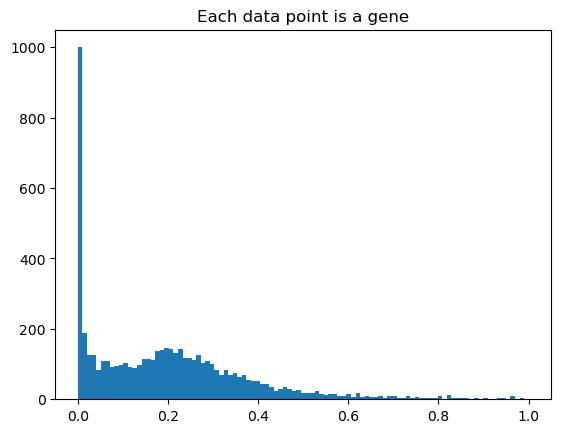

In [15]:
plt.hist(mse_across_cells, bins=np.linspace(0, 1, 100));
plt.title('Each data point is a gene');

In [16]:
test_names = adata.var.index[keep_genes]

name = test_names[np.nanargmax(r_values_across_cells)]
print(name)

ENSG00000171053


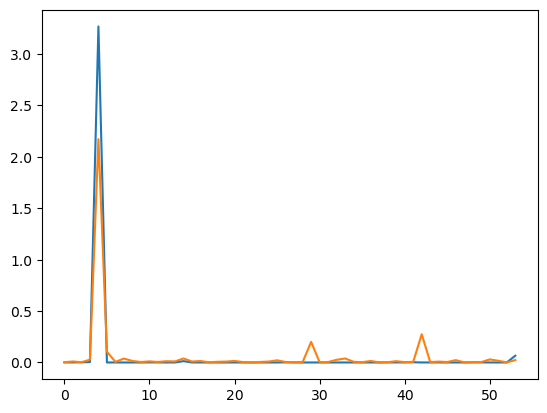

In [17]:
plt.plot(X[:, test_names == name]);
plt.plot(X_pred[:, test_names == name]);

-0.14933786773431798


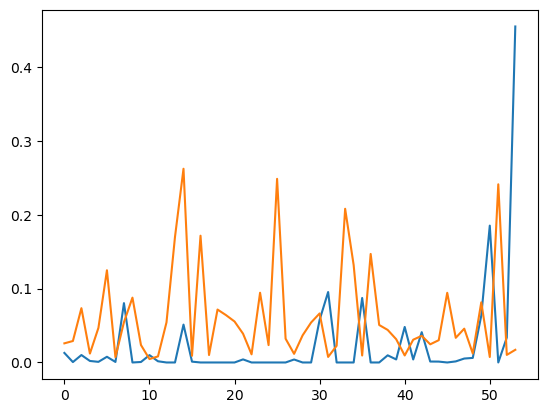

In [18]:
gene_num = 1105
plt.plot(X[:, gene_num]);
plt.plot(X_pred[:, gene_num]);
print(r_values_across_cells[gene_num]);

Text(0.5, 1.0, '+/- strand genes')

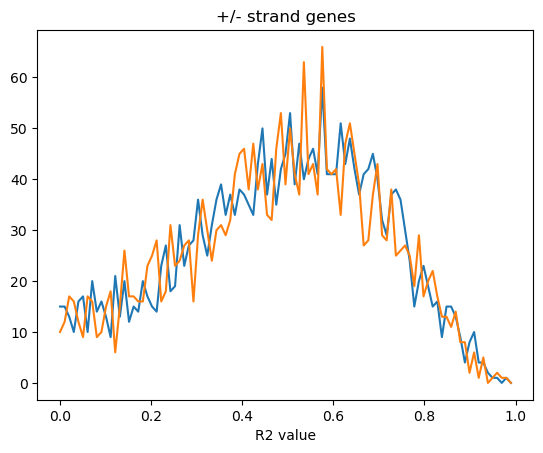

In [19]:
test_strand = adata.var['column_4'][keep_genes]

v_p, b = np.histogram(r_values_across_cells[test_strand == '+'], bins=np.linspace(0, 1, 100));
v_n, b = np.histogram(r_values_across_cells[test_strand == '-'], bins=np.linspace(0, 1, 100));
plt.plot(b[:-1], v_p);
plt.plot(b[:-1], v_n);
plt.xlabel('R2 value')
plt.title('+/- strand genes')

Text(0.5, 1.0, 'Chrom')

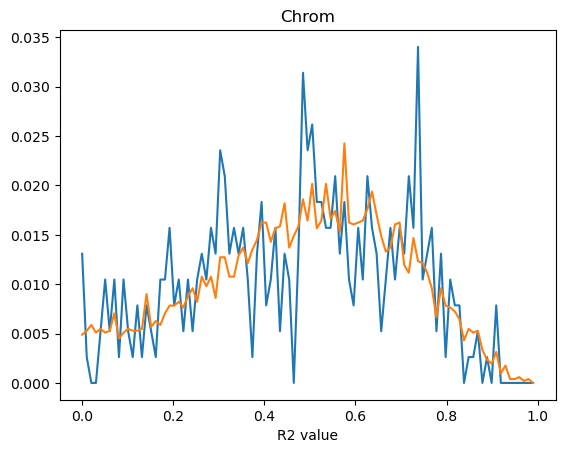

In [20]:
test_chrom = adata.var['column_1'][keep_genes]

v_p, b = np.histogram(r_values_across_cells[test_chrom == '19'], bins=np.linspace(0, 1, 100));
v_n, b = np.histogram(r_values_across_cells, bins=np.linspace(0, 1, 100));
plt.plot(b[:-1], v_p / v_p.sum());
plt.plot(b[:-1], v_n / v_n.sum());
plt.xlabel('R2 value')
plt.title('Chrom')

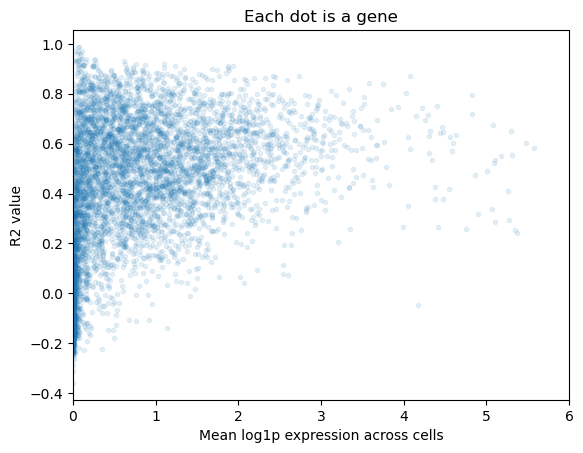

In [21]:
plt.plot(X.mean(axis=0), r_values_across_cells, '.', alpha=0.1);
plt.xlabel('Mean log1p expression across cells');
plt.ylabel('R2 value');
plt.title('Each dot is a gene');
plt.xlim([0, 6]);

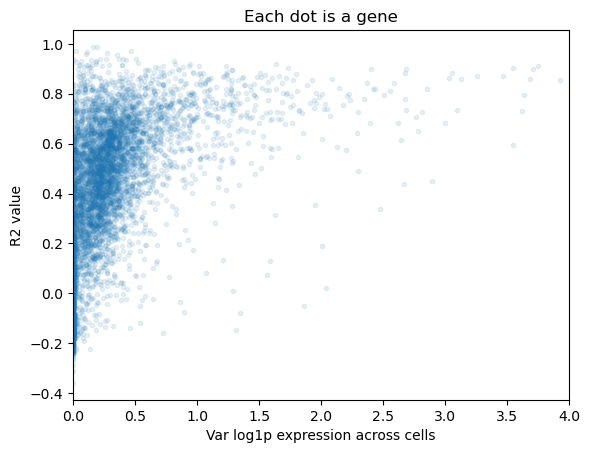

In [22]:
plt.plot(X.var(axis=0), r_values_across_cells, '.', alpha=0.1);
plt.xlabel('Var log1p expression across cells');
plt.ylabel('R2 value');
plt.title('Each dot is a gene');
plt.xlim([0, 4]);

In [23]:
r_values_across_genes = np.array([pearsonr(a, b).statistic for a, b in zip(X, X_pred)])
print(len(r_values_across_genes), r_values_across_genes.mean())

54 0.899234735950436


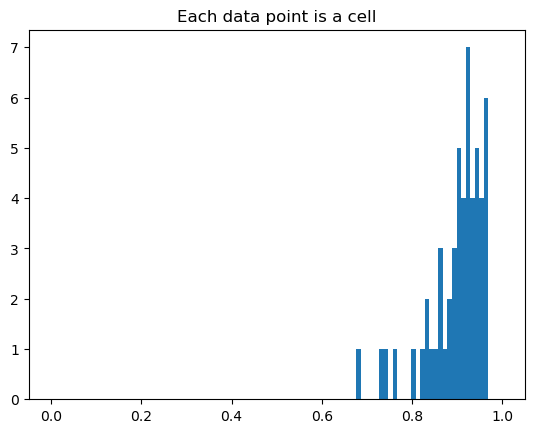

In [24]:
plt.hist(r_values_across_genes, bins=np.linspace(0, 1, 100));
plt.title('Each data point is a cell');

Text(0.5, 1.0, 'Expression')

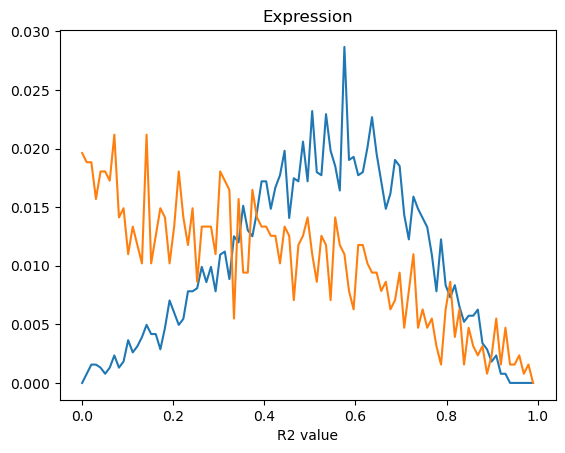

In [25]:
v_n, b = np.histogram(r_values_across_cells[X.mean(axis=0) <+ 0.2], bins=np.linspace(0, 1, 100));
v_p, b = np.histogram(r_values_across_cells[X.mean(axis=0) > 0.2], bins=np.linspace(0, 1, 100));
# plt.plot(b[:-1], v_a / v_a.sum());
plt.plot(b[:-1], v_p / v_p.sum());
plt.plot(b[:-1], v_n / v_n.sum());
plt.xlabel('R2 value')
plt.title('Expression')

/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_11564/3483486417.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(b[:-1], v_n / v_n.sum());


Text(0.5, 1.0, 'Biotype')

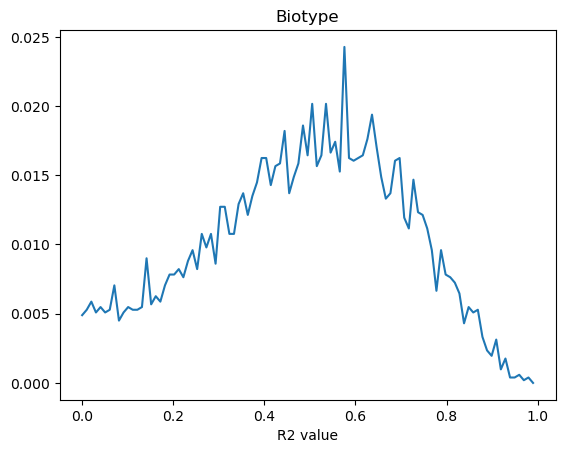

In [26]:
test_biotype = adata.var['gene_biotype'][keep_genes]

v_n, b = np.histogram(r_values_across_cells[test_biotype != 'protein_coding'], bins=np.linspace(0, 1, 100));
v_p, b = np.histogram(r_values_across_cells[test_biotype == 'protein_coding'], bins=np.linspace(0, 1, 100));
v_a, b = np.histogram(r_values_across_cells, bins=np.linspace(0, 1, 100));
# plt.plot(b[:-1], v_a / v_a.sum());
plt.plot(b[:-1], v_p / v_p.sum());
plt.plot(b[:-1], v_n / v_n.sum());
plt.xlabel('R2 value')
plt.title('Biotype')

/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_11564/3138457900.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(b[:-1], v_n / v_n.sum());


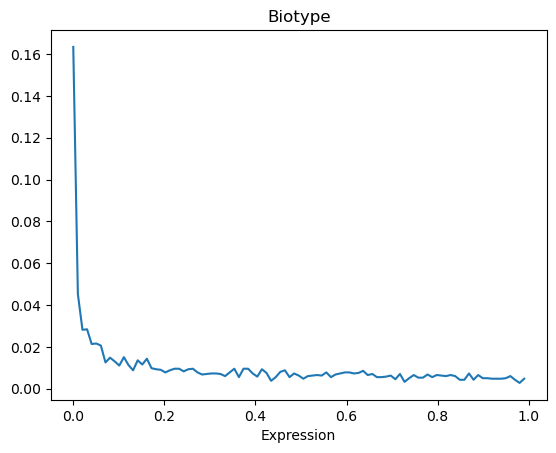

In [27]:
test_biotype = adata.var['gene_biotype'][keep_genes]

v_p, b = np.histogram(X.mean(axis=0)[test_biotype == 'protein_coding'], bins=np.linspace(0, 1, 100));
v_n, b = np.histogram(X.mean(axis=0)[test_biotype != 'protein_coding'], bins=np.linspace(0, 1, 100));
# plt.plot(b[:-1], v_a / v_a.sum());
plt.plot(b[:-1], v_p / v_p.sum());
plt.plot(b[:-1], v_n / v_n.sum());
plt.xlabel('Expression');
plt.title('Biotype');

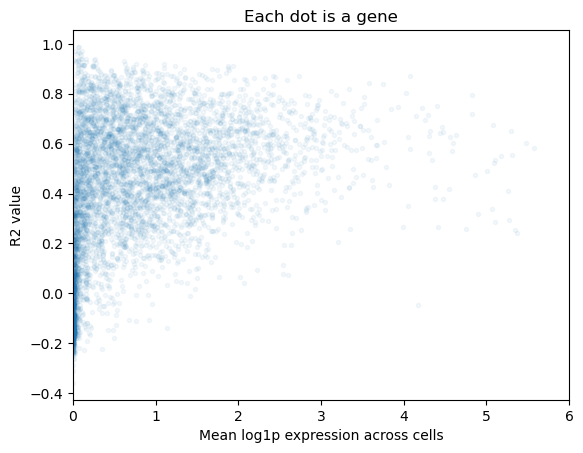

In [28]:
plt.plot(X.mean(axis=0)[test_biotype == 'protein_coding'], r_values_across_cells[test_biotype == 'protein_coding'], '.', alpha=0.05);
plt.plot(X.mean(axis=0)[test_biotype != 'protein_coding'], r_values_across_cells[test_biotype != 'protein_coding'], '.', alpha=0.05);
plt.xlabel('Mean log1p expression across cells');
plt.ylabel('R2 value');
plt.title('Each dot is a gene');
plt.xlim([0, 6]);

In [29]:
print((X.mean(axis=0) > 0.5).sum())
print((test_biotype == 'protein_coding').sum())
print(np.logical_and(test_biotype == 'protein_coding', X.mean(axis=0) > 0.5).sum())

2967
5791
2967


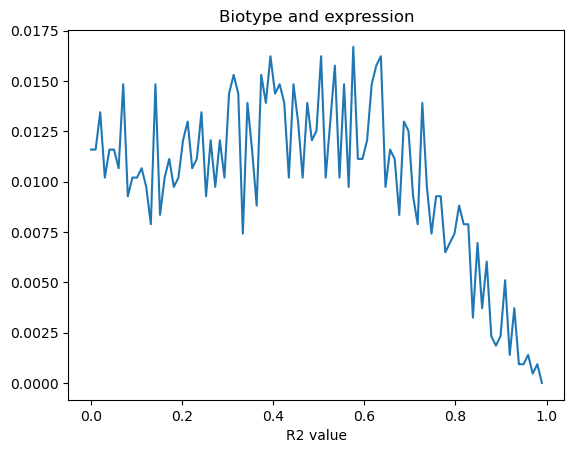

In [30]:
test_biotype = adata.var['gene_biotype'][keep_genes]

v_p, b = np.histogram(r_values_across_cells[np.logical_and(test_biotype == 'protein_coding', X.mean(axis=0) <= 0.5)], bins=np.linspace(0, 1, 100));
plt.plot(b[:-1], v_p / v_p.sum());
plt.xlabel('R2 value')
plt.title('Biotype and expression');

In [31]:
print(np.nanmean(r_values_across_cells[X.var(axis=0) > 0.5]))
print(np.nanmean(r_values_across_cells[X.var(axis=0) <= 0.5]))
print(r_values_across_genes.mean())

0.6494837240854685
0.372846030061963
0.899234735950436


In [32]:
val = X.var(axis=0)
# val = r_values_across_cells
show_genes = np.where(val >= np.percentile(val, 95))[0]

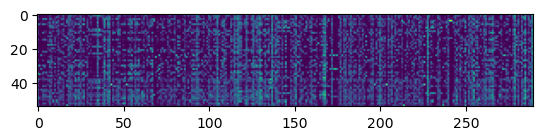

In [33]:
plt.imshow(X[:, show_genes]);


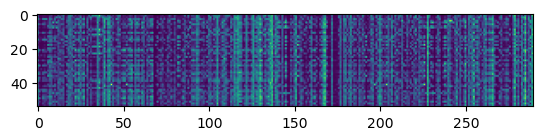

In [34]:
plt.imshow(X_pred[:, show_genes]);

In [35]:
# expression.layers['prediction'] = X_pred_full
# expression.layers['prediction'][expression.layers['prediction'] < 0.1] = 0

In [36]:
import scanpy as sc

In [37]:
del adata.uns['log1p']
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [38]:
marker_genes_inds = adata[:, keep_genes].var[adata[:, keep_genes].var['highly_variable']]
marker_genes_all = marker_genes_inds['feature_name'].values
marker_genes = np.random.choice(marker_genes_all, 50)

In [39]:
# marker_genes_all = expression[:, keep_genes].var[r_values_across_cells >= 0.95]['feature_name'].values
# marker_genes = np.random.choice(marker_genes_all, 50)

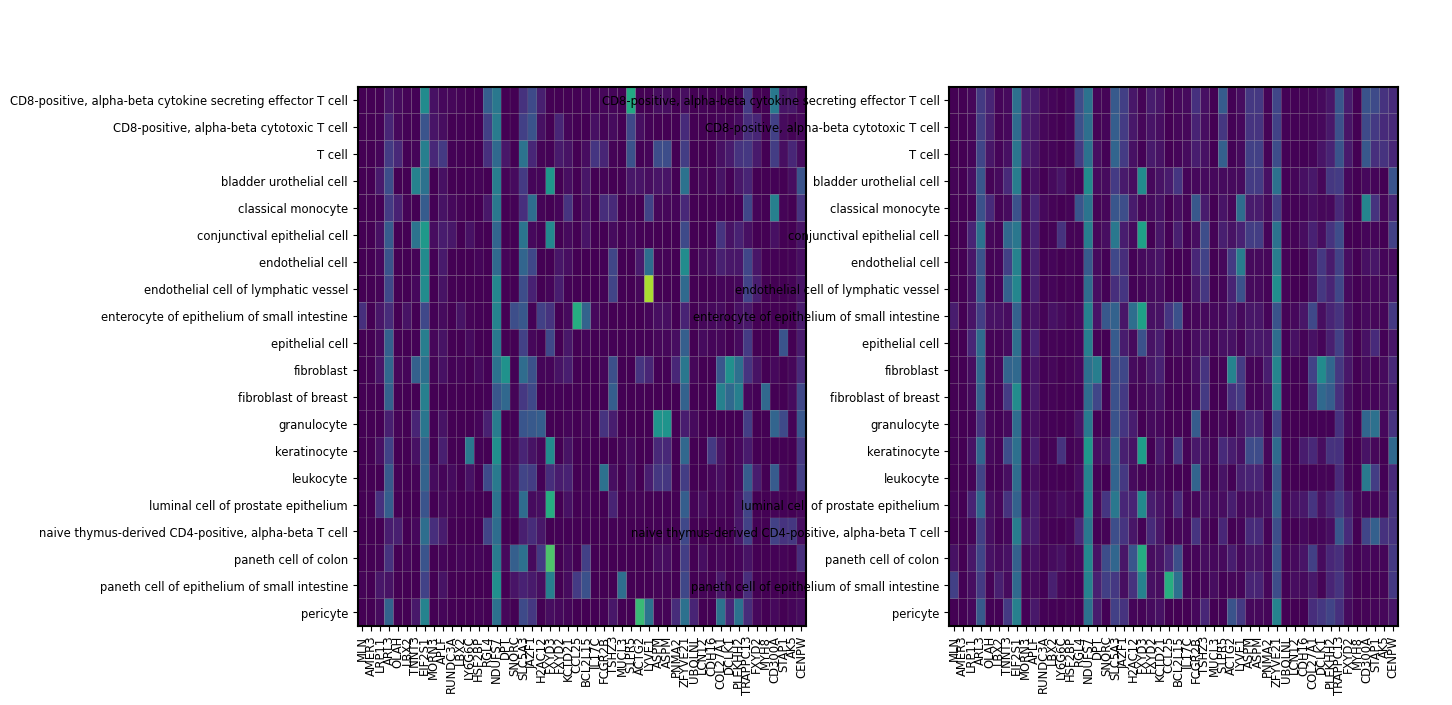

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'wspace':0.2})
sc.pl.matrixplot(adata[keep_cells][:20], marker_genes, groupby='cell_type', gene_symbols='feature_name', layer='counts_normalized',
                 vmin=0, vmax=6, ax=ax1, show=False);
fig.axes[-1].remove()
fig.axes[-1].remove()
sc.pl.matrixplot(adata[keep_cells][:20], marker_genes, groupby='cell_type', gene_symbols='feature_name', layer='scvi_normalized',
                 vmin=0, vmax=6, ax=ax2, show=False);
fig.axes[-1].remove()
fig.axes[-1].remove()
# ax2.set_visible(False)

(0.0, 5.0)

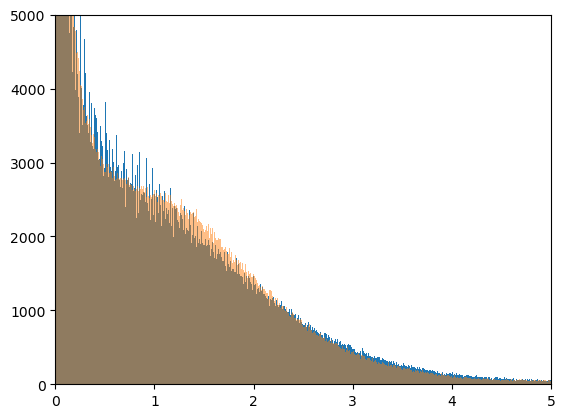

In [41]:
plt.hist(np.asarray(adata[keep_cells].layers['counts_normalized'].flatten()), bins=1000);
plt.hist(np.asarray(adata[keep_cells].layers['scvi_normalized'].flatten()), bins=1000, alpha=0.5);
plt.ylim([0, 5000])
plt.xlim([0, 5])

In [42]:
(adata.X == 0).sum() / np.prod(adata.X.shape)

0.1642931106828775

In [43]:
# expression.obs['type'] = expression.obs['cell_type'].values.tolist()
# expression.obs['type'][expression.obs['type'].isnull()] = expression.obs['tissue'][expression.obs['type'].isnull()].values.tolist()
# expression.obs['type'] = expression.obs['type'].astype('category')

In [44]:
# sc.tl.rank_genes_groups(expression, 'type', method='logreg')

In [45]:
marker_genes_scvi = {'B cell': ['ENSG00000089012', 'ENSG00000143297', 'ENSG00000239961'],
 'CD1c-positive myeloid dendritic cell': ['ENSG00000151012',
  'ENSG00000034152',
  'ENSG00000104885'],
 'CD4-positive helper T cell': ['ENSG00000089012',
  'ENSG00000102055',
  'ENSG00000100346'],
 'CD4-positive, alpha-beta T cell': ['ENSG00000139193',
  'ENSG00000180739',
  'ENSG00000179934'],
 'CD4-positive, alpha-beta memory T cell': ['ENSG00000183813',
  'ENSG00000180739',
  'ENSG00000177272'],
 'CD8-positive, alpha-beta T cell': ['ENSG00000180739',
  'ENSG00000116824',
  'ENSG00000179934'],
 'CD8-positive, alpha-beta cytokine secreting effector T cell': ['ENSG00000122223',
  'ENSG00000189430',
  'ENSG00000168229'],
 'CD8-positive, alpha-beta cytotoxic T cell': ['ENSG00000183813',
  'ENSG00000112297',
  'ENSG00000173762'],
 'CD8-positive, alpha-beta memory T cell': ['ENSG00000180739',
  'ENSG00000183813',
  'ENSG00000101082'],
 'CD141-positive myeloid dendritic cell': ['ENSG00000109321',
  'ENSG00000059728',
  'ENSG00000172939'],
 'DN1 thymic pro-T cell': ['ENSG00000198851',
  'ENSG00000173762',
  'ENSG00000213402'],
 'DN3 thymocyte': ['ENSG00000213402', 'ENSG00000173762', 'ENSG00000198851'],
 'Mueller cell': ['ENSG00000144227', 'ENSG00000149483', 'ENSG00000184378'],
 'T cell': ['ENSG00000100721', 'ENSG00000174946', 'ENSG00000172215'],
 'T follicular helper cell': ['ENSG00000173762',
  'ENSG00000183813',
  'ENSG00000213402'],
 'acinar cell of salivary gland': ['ENSG00000164825',
  'ENSG00000205649',
  'ENSG00000162078'],
 'adventitial cell': ['ENSG00000000005', 'ENSG00000164161', 'ENSG00000125730'],
 'basal cell': ['ENSG00000264230', 'ENSG00000169474', 'ENSG00000175315'],
 'basal cell of prostate epithelium': ['ENSG00000237353',
  'ENSG00000167580',
  'ENSG00000186526'],
 'basophil': ['ENSG00000010671', 'ENSG00000095917', 'ENSG00000149534'],
 'bladder urothelial cell': ['ENSG00000100373',
  'ENSG00000167653',
  'ENSG00000136872'],
 'bronchial smooth muscle cell': ['ENSG00000131055',
  'ENSG00000177791',
  'ENSG00000198467'],
 'capillary endothelial cell': ['ENSG00000161649',
  'ENSG00000142748',
  'ENSG00000274736'],
 'cardiac endothelial cell': ['ENSG00000085276',
  'ENSG00000120937',
  'ENSG00000120279'],
 'cardiac muscle cell': ['ENSG00000156885',
  'ENSG00000159251',
  'ENSG00000173991'],
 'ciliated cell': ['ENSG00000115423', 'ENSG00000187905', 'ENSG00000158486'],
 'classical monocyte': ['ENSG00000163221',
  'ENSG00000161944',
  'ENSG00000196209'],
 'club cell': ['ENSG00000131400', 'ENSG00000110195', 'ENSG00000136352'],
 'common myeloid progenitor': ['ENSG00000169575',
  'ENSG00000250361',
  'ENSG00000204420'],
 'conjunctival epithelial cell': ['ENSG00000187242',
  'ENSG00000184292',
  'ENSG00000134757'],
 'connective tissue cell': ['ENSG00000174807',
  'ENSG00000000971',
  'ENSG00000091986'],
 'corneal epithelial cell': ['ENSG00000205076',
  'ENSG00000121742',
  'ENSG00000186442'],
 'dendritic cell': ['ENSG00000158481', 'ENSG00000179639', 'ENSG00000158485'],
 'duct epithelial cell': ['ENSG00000171201',
  'ENSG00000171195',
  'ENSG00000100285'],
 'effector CD4-positive, alpha-beta T cell': ['ENSG00000166105',
  'ENSG00000101082',
  'ENSG00000156886'],
 'effector CD8-positive, alpha-beta T cell': ['ENSG00000156886',
  'ENSG00000166105',
  'ENSG00000049768'],
 'endothelial cell': ['ENSG00000140465', 'ENSG00000142748', 'ENSG00000066056'],
 'endothelial cell of artery': ['ENSG00000157554',
  'ENSG00000142748',
  'ENSG00000147378'],
 'endothelial cell of hepatic sinusoid': ['ENSG00000138315',
  'ENSG00000182566',
  'ENSG00000173530'],
 'endothelial cell of lymphatic vessel': ['ENSG00000142748',
  'ENSG00000120156',
  'ENSG00000154133'],
 'endothelial cell of vascular tree': ['ENSG00000142748',
  'ENSG00000156298',
  'ENSG00000161649'],
 'enterocyte': ['ENSG00000134193', 'ENSG00000016490', 'ENSG00000172016'],
 'enterocyte of epithelium of large intestine': ['ENSG00000198788',
  'ENSG00000070985',
  'ENSG00000044012'],
 'enterocyte of epithelium of small intestine': ['ENSG00000198788',
  'ENSG00000275395',
  'ENSG00000164816'],
 'epithelial cell': ['ENSG00000184956', 'ENSG00000124233', 'ENSG00000075886'],
 'epithelial cell of lacrimal sac': ['ENSG00000136688',
  'ENSG00000187242',
  'ENSG00000129194'],
 'epithelial cell of uterus': ['ENSG00000078081',
  'ENSG00000119457',
  'ENSG00000135245'],
 'erythrocyte': ['ENSG00000163737', 'ENSG00000159339', 'ENSG00000105507'],
 'erythroid progenitor cell': ['ENSG00000166947',
  'ENSG00000250361',
  'ENSG00000181418'],
 'eye photoreceptor cell': ['ENSG00000101132',
  'ENSG00000101079',
  'ENSG00000087274'],
 'fast muscle cell': ['ENSG00000184343', 'ENSG00000067191', 'ENSG00000179262'],
 'fibroblast': ['ENSG00000077942', 'ENSG00000163710', 'ENSG00000174807'],
 'fibroblast of breast': ['ENSG00000178860',
  'ENSG00000172061',
  'ENSG00000120332'],
 'fibroblast of cardiac tissue': ['ENSG00000106823',
  'ENSG00000188783',
  'ENSG00000185610'],
 'goblet cell': ['ENSG00000138109', 'ENSG00000088386', 'ENSG00000248144'],
 'granulocyte': ['ENSG00000164821', 'ENSG00000172232', 'ENSG00000196415'],
 'gut endothelial cell': ['ENSG00000235387',
  'ENSG00000142748',
  'ENSG00000110799'],
 'hematopoietic stem cell': ['ENSG00000185155',
  'ENSG00000255526',
  'ENSG00000169607'],
 'hepatocyte': ['ENSG00000101981', 'ENSG00000158874', 'ENSG00000113889'],
 'innate lymphoid cell': ['ENSG00000180739',
  'ENSG00000183813',
  'ENSG00000138795'],
 'intermediate monocyte': ['ENSG00000163221',
  'ENSG00000101916',
  'ENSG00000196209'],
 'intestinal crypt stem cell': ['ENSG00000160181',
  'ENSG00000196188',
  'ENSG00000134193'],
 'intestinal crypt stem cell of large intestine': ['ENSG00000198788',
  'ENSG00000070985',
  'ENSG00000251287'],
 'intestinal crypt stem cell of small intestine': ['ENSG00000171747',
  'ENSG00000198788',
  'ENSG00000138109'],
 'intestinal enteroendocrine cell': ['ENSG00000173404',
  'ENSG00000176919',
  'ENSG00000184530'],
 'intestinal tuft cell': ['ENSG00000131089',
  'ENSG00000274997',
  'ENSG00000273802'],
 'ionocyte': ['ENSG00000132950', 'ENSG00000023191', 'ENSG00000176945'],
 'keratinocyte': ['ENSG00000169509', 'ENSG00000185873', 'ENSG00000163209'],
 'keratocyte': ['ENSG00000090539', 'ENSG00000188770', 'ENSG00000044524'],
 'kidney epithelial cell': ['ENSG00000120053',
  'ENSG00000176974',
  'ENSG00000116791'],
 'large intestine goblet cell': ['ENSG00000198788',
  'ENSG00000122711',
  'ENSG00000198488'],
 'leukocyte': ['ENSG00000127318', 'ENSG00000112116', 'ENSG00000203908'],
 'luminal cell of prostate epithelium': ['ENSG00000150394',
  'ENSG00000119411',
  'ENSG00000185290'],
 'luminal epithelial cell of mammary gland': ['ENSG00000148513',
  'ENSG00000124157',
  'ENSG00000186526'],
 'lung ciliated cell': ['ENSG00000121064',
  'ENSG00000143222',
  'ENSG00000166171'],
 'lung microvascular endothelial cell': ['ENSG00000122679',
  'ENSG00000161649',
  'ENSG00000145708'],
 'macrophage': ['ENSG00000276085', 'ENSG00000136634', 'ENSG00000173391'],
 'mast cell': ['ENSG00000157404', 'ENSG00000101197', 'ENSG00000141433'],
 'mature NK T cell': ['ENSG00000138795', 'ENSG00000180739', 'ENSG00000179639'],
 'medullary thymic epithelial cell': ['ENSG00000152266',
  'ENSG00000243566',
  'ENSG00000147647'],
 'melanocyte': ['ENSG00000130766', 'ENSG00000128203', 'ENSG00000067048'],
 'memory B cell': ['ENSG00000177455', 'ENSG00000159958', 'ENSG00000136573'],
 'mesenchymal stem cell': ['ENSG00000000005',
  'ENSG00000104213',
  'ENSG00000163710'],
 'microglial cell': ['ENSG00000105963', 'ENSG00000129450', 'ENSG00000117115'],
 'monocyte': ['ENSG00000078579', 'ENSG00000196209', 'ENSG00000223638'],
 'mucus secreting cell': ['ENSG00000215182',
  'ENSG00000124143',
  'ENSG00000142224'],
 'muscle cell': ['ENSG00000088930', 'ENSG00000076706', 'ENSG00000186281'],
 'myeloid cell': ['ENSG00000158485', 'ENSG00000029559', 'ENSG00000186407'],
 'myoepithelial cell': ['ENSG00000124939',
  'ENSG00000104332',
  'ENSG00000184254'],
 'myofibroblast cell': ['ENSG00000166482',
  'ENSG00000139329',
  'ENSG00000197614'],
 'myometrial cell': ['ENSG00000187479', 'ENSG00000151617', 'ENSG00000112214'],
 'naive B cell': ['ENSG00000163534', 'ENSG00000132704', 'ENSG00000177455'],
 'naive regulatory T cell': ['ENSG00000180739',
  'ENSG00000183813',
  'ENSG00000101082'],
 'naive thymus-derived CD4-positive, alpha-beta T cell': ['ENSG00000179934',
  'ENSG00000180739',
  'ENSG00000138795'],
 'naive thymus-derived CD8-positive, alpha-beta T cell': ['ENSG00000189430',
  'ENSG00000101082',
  'ENSG00000168229'],
 'neutrophil': ['ENSG00000179344', 'ENSG00000162747', 'ENSG00000130561'],
 'non-classical monocyte': ['ENSG00000085514',
  'ENSG00000101160',
  'ENSG00000110077'],
 'pancreatic A cell': ['ENSG00000258986',
  'ENSG00000115419',
  'ENSG00000175203'],
 'pancreatic PP cell': ['ENSG00000101746',
  'ENSG00000162374',
  'ENSG00000164756'],
 'pancreatic acinar cell': ['ENSG00000179751',
  'ENSG00000175535',
  'ENSG00000091704'],
 'pancreatic ductal cell': ['ENSG00000133661',
  'ENSG00000143954',
  'ENSG00000187021'],
 'pancreatic stellate cell': ['ENSG00000172156',
  'ENSG00000156234',
  'ENSG00000138356'],
 'paneth cell of colon': ['ENSG00000275395',
  'ENSG00000016490',
  'ENSG00000173702'],
 'paneth cell of epithelium of small intestine': ['ENSG00000134193',
  'ENSG00000173702',
  'ENSG00000088386'],
 'pericyte': ['ENSG00000166482', 'ENSG00000139329', 'ENSG00000004776'],
 'plasma cell': ['ENSG00000099958', 'ENSG00000170476', 'ENSG00000254709'],
 'plasmacytoid dendritic cell': ['ENSG00000139370',
  'ENSG00000057608',
  'ENSG00000140968'],
 'platelet': ['ENSG00000156642', 'ENSG00000117400', 'ENSG00000185825'],
 'radial glial cell': ['ENSG00000187242',
  'ENSG00000197632',
  'ENSG00000134757'],
 'regulatory T cell': ['ENSG00000180739',
  'ENSG00000138795',
  'ENSG00000175857'],
 'respiratory goblet cell': ['ENSG00000167653',
  'ENSG00000161055',
  'ENSG00000124107'],
 'retinal blood vessel endothelial cell': ['ENSG00000169908',
  'ENSG00000196611',
  'ENSG00000142748'],
 'secretory cell': ['ENSG00000198183', 'ENSG00000138152', 'ENSG00000140274'],
 'skeletal muscle satellite stem cell': ['ENSG00000165887',
  'ENSG00000111046',
  'ENSG00000164122'],
 'slow muscle cell': ['ENSG00000213341', 'ENSG00000135775', 'ENSG00000182512'],
 'small intestine goblet cell': ['ENSG00000198788',
  'ENSG00000198488',
  'ENSG00000184305'],
 'smooth muscle cell': ['ENSG00000151617',
  'ENSG00000198523',
  'ENSG00000112214'],
 'stem cell': ['ENSG00000187242', 'ENSG00000189280', 'ENSG00000205076'],
 'stromal cell': ['ENSG00000149968', 'ENSG00000101441', 'ENSG00000145423'],
 'surface ectodermal cell': ['ENSG00000080166',
  'ENSG00000107165',
  'ENSG00000075213'],
 'tendon cell': ['ENSG00000000005', 'ENSG00000034971', 'ENSG00000141338'],
 'thymocyte': ['ENSG00000107447', 'ENSG00000183813', 'ENSG00000178562'],
 'tongue muscle cell': ['ENSG00000126653',
  'ENSG00000120008',
  'ENSG00000101126'],
 'tracheal goblet cell': ['ENSG00000140506',
  'ENSG00000166948',
  'ENSG00000117407'],
 'transit amplifying cell of colon': ['ENSG00000128311',
  'ENSG00000115263',
  'ENSG00000163900'],
 'transit amplifying cell of small intestine': ['ENSG00000110244',
  'ENSG00000137251',
  'ENSG00000196188'],
 'type B pancreatic cell': ['ENSG00000124568',
  'ENSG00000145642',
  'ENSG00000100253'],
 'type I NK T cell': ['ENSG00000189430', 'ENSG00000240403', 'ENSG00000175857'],
 'type I pneumocyte': ['ENSG00000123838',
  'ENSG00000131400',
  'ENSG00000133661'],
 'type II pneumocyte': ['ENSG00000131400',
  'ENSG00000133661',
  'ENSG00000183607'],
 'vascular associated smooth muscle cell': ['ENSG00000111404',
  'ENSG00000173641',
  'ENSG00000139329'],
 'vein endothelial cell': ['ENSG00000142748',
  'ENSG00000122679',
  'ENSG00000161649']}

In [46]:
len(marker_genes_scvi)

132

In [47]:
import pandas as pd


marker_genes = []
keep_cells_plot = []
for cell_id in np.where(keep_cells)[0][:20]:
    cell_type = adata.obs['cell_type'].iloc[cell_id]
    if not pd.isnull(cell_type):
        marker_genes += marker_genes_scvi[cell_type]
        keep_cells_plot.append(cell_id)

marker_genes = adata.var.loc[marker_genes]['feature_name'].values

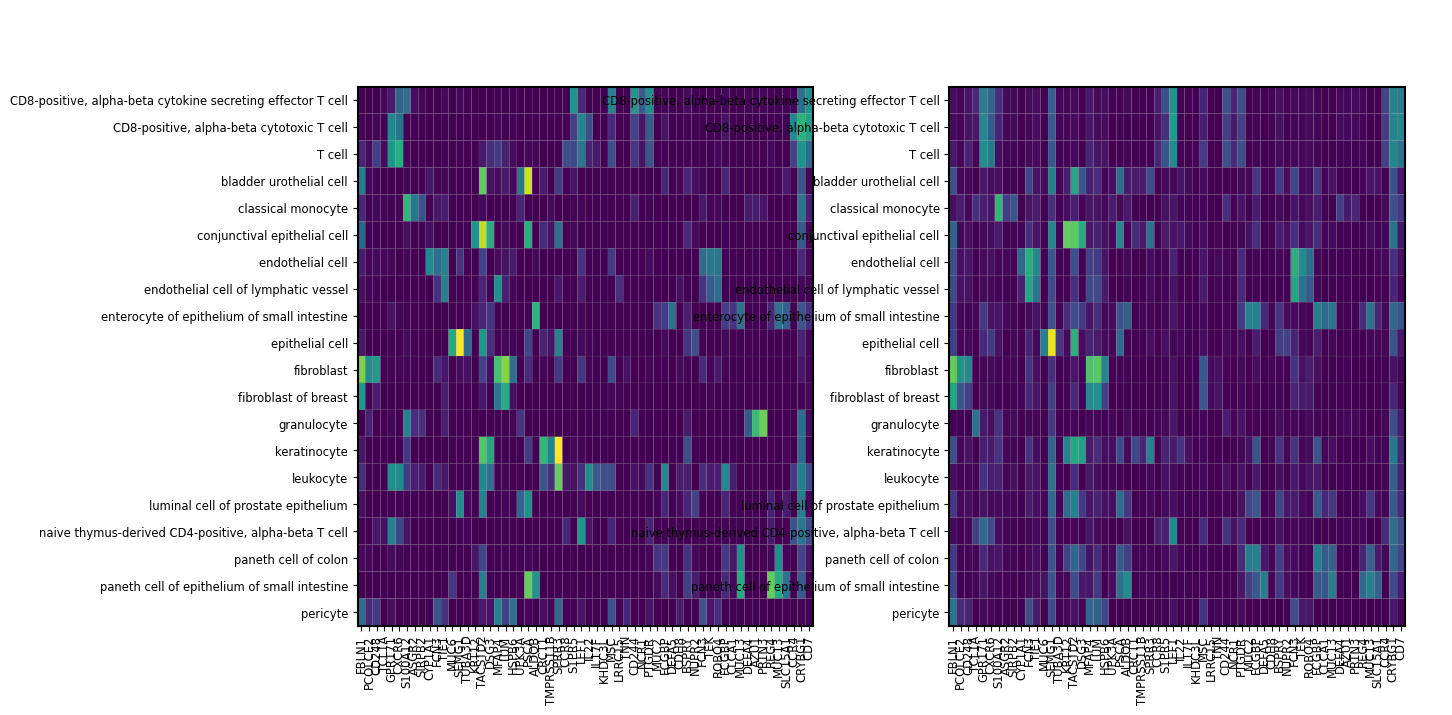

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'wspace':0.2})
sc.pl.matrixplot(adata[keep_cells_plot], marker_genes, groupby='cell_type', gene_symbols='feature_name', layer='counts_normalized',
                 vmin=0, vmax=7, ax=ax1, show=False);
fig.axes[-1].remove()
fig.axes[-1].remove()
sc.pl.matrixplot(adata[keep_cells_plot], marker_genes, groupby='cell_type', gene_symbols='feature_name', layer='scvi_normalized',
                 vmin=0, vmax=7, ax=ax2, show=False);
fig.axes[-1].remove()
fig.axes[-1].remove()